# Geosüsteemide modelleerimine

__Prof. Evelyn Uuemaa__

- Praktikumi lisa

    Tudengid laevad üles oma CSV-faili ja saavad selle põhjal teha regressioon analüüsi.

## Kuidas seda skripti kasutada

Mine hiirega kõige esimesele kastile ja vajuta "Run" nuppu, et üksus läbi jooksutada ja minna järgmiste plokkide juurde. Kui midagi valesti läheb, saad sa lihtsasti uuesti algusest alustada. Mõnes plokis on vaja osad sisendväärtused muuta. Need on tähistatud suurte tähtedega MUUDA SIIN

In [83]:
# Impordi vajalikud paketid
from IPython.display import display
import ipywidgets as widgets

import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

sns.set_theme(style="whitegrid")

%matplotlib inline

Ülejärgmise ploki juures tuleb sul arvutist valida äsja salvestatud CSV-fail. Kui sinu CSV-faili eraldusmärgiks on koma, pole vaja midagi muuta. Kui aga semikoolon, tee muutus järgmises plokis: csv_delimiter = ";".

In [84]:
upload = widgets.FileUpload( accept='.csv', multiple=False )

csv_delimiter = ","
text_encoding = "utf8"

In [18]:
upload

FileUpload(value=(), accept='.csv', description='Upload')

In [85]:
# võta see maha lõplikust scriptis
data = pd.read_csv('saksamaa_temp_dem_sampled.csv', encoding=text_encoding, sep=csv_delimiter)
data.head(10)

,fid,punkti_id,temp_1,dem_1
0,1,1,0.3,90.925026
1,2,2,2.4,122.270454
2,3,3,1.5,387.505951
3,4,4,-1.1,500.983978
4,5,5,1.3,192.927658
5,6,6,-0.4,458.119934
6,7,7,1.5,-0.668177
7,8,8,0.4,111.623970
8,9,9,1.3,281.307281
9,10,10,1.4,124.067711


Kui oled faili oma arvutist valinud, peaks üleslaadimise lahter näitama "Upload (1)", mis tähendab, et fail on nüüd valitud.

Jooksuta läbi järgmine plokk. Tulemuseks peaks olema ilus tabel, mitte ühes jorus tekst. Kui näed väärtuste vahel semikooloneid (;), tuleb teises plokis teha parandus (csv_delimiter = ";").

In [86]:
#filestream_encoding = "utf8"

t = upload.data[0].decode(encoding=filestream_encoding)

with open('tmp.csv', 'w', encoding=text_encoding) as fh:
    fh.write(t)

data = pd.read_csv('tmp.csv', encoding=text_encoding, sep=csv_delimiter)

data.head(10)

AttributeError: 'FileUpload' object has no attribute 'data'

### Sõltuva ja sõltumatu tunnuse määratlemine
Defineeri esmalt sõltumatu ja sõltuva tunnuse.

In [87]:
# Defineeri sõltuv muutuja (Y) ja sõltumatu muutuja (X)
# MUUDA SIIN: vaata oma tabelit ja vali õiged väärtused sõltumatuks ja sõltuvaks muutujaks
Y = data['temp_1']  # Kirjuta "Sõltuva muutuja" asemele õige veeru nimi tabelist
X = data[['dem_1']]  # Kirjuta "Sõltumatu muutuja" asemele õige veeru nimi tabelist

### Normaaljaotuse testimine
Testi, kas sinu sõltumatu ja sõltuv tunnus on normaaljaotusega. Regressioonanalüüsi eeluseks on, et tunnused on normaaljaotusega. Juhul kui tunnused ei  ole normaaljaotusele vastavad, siis võib ikkagi regressioonanalüüsi teha, aga tõenäoliselt on tulemused kehvemad kui normaaljaotusega võiks eeldada.

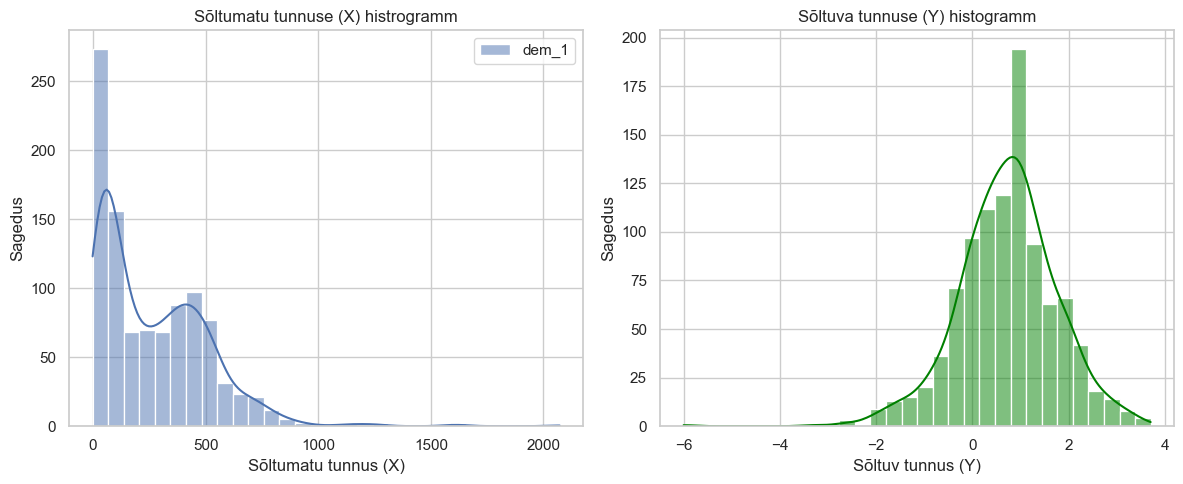

Shapiro-Wilk Test normaaljaotuse jaoks:
X: Statistic=0.8718585685909661, p-value=7.425850473092442e-28
Y: Statistic=0.981674665508133, p-value=6.778846565843935e-10
X ei ole normaaljaotusega (lükka H0 ümber)
Y ei ole normaaljaotusega (lükka H0 ümber)


In [88]:
# Plot histograms for X and Y
plt.figure(figsize=(12, 5))

# Sõltumatu tunnuse histogramm
plt.subplot(1, 2, 1)
sns.histplot(X, bins=30, kde=True, color='blue')
plt.title('Sõltumatu tunnuse (X) histrogramm')
plt.xlabel('Sõltumatu tunnus (X)')
plt.ylabel('Sagedus')

# Sõltuva tunnuse histogramm
plt.subplot(1, 2, 2)
sns.histplot(Y, bins=30, kde=True, color='green')
plt.title('Sõltuva tunnuse (Y) histogramm')
plt.xlabel('Sõltuv tunnus (Y)')
plt.ylabel('Sagedus')

plt.tight_layout()
plt.show()

# Normaaljaotuse test  - Shapiro-Wilk test
shapiro_X = stats.shapiro(X)
shapiro_Y = stats.shapiro(Y)

print("Shapiro-Wilk Test normaaljaotuse jaoks:")
print(f"X: Statistic={shapiro_X.statistic}, p-value={shapiro_X.pvalue}")
print(f"Y: Statistic={shapiro_Y.statistic}, p-value={shapiro_Y.pvalue}")

# p-väärtuse interpreteerimine
alpha = 0.05
for variable, result in zip(['X', 'Y'], [shapiro_X, shapiro_Y]):
    if result.pvalue < alpha:
        print(f"{variable} ei ole normaaljaotusega (lükka H0 ümber)")
    else:
        print(f"{variable} on normaaljaotusega (ei saa H0 ümber lükata)")

#### Normaaljaotuse testi tulemuste interpreteerimine

Nagu tulemustest näha, siis ei ole tunnused normaaljaotusega. Sellegipoolest võime kasutada regressioonanalüüsi, aga tuleb lihtsalt arvestada sellega, et mudel ei pruugi anda nii head tulemust kui mõni mitte-parameetriline mudel.

## Sisendandmete treening- ja valideerimisandmeteks jagamine
Selleks, et saaksime testida mudelit sõltumatute andmete peal (andmed, mida mudel pole varem näinud), jagame andmed kaheks. 70% andmetest jätame treeningandmeteks, mille alusel loome mudeli ning 30% andmetest jätame valideerimiseks. Valideerimisandmete peal mudelit rakendades saame teada kui hästi mudel tegelikult töötab.

In [89]:
# Tee valim kaheks - treeningandmeteks (70%) ja valideerimisandmeteks (30%)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

## Treeni mudel ja prognoosi


Training Model Summary:
                            OLS Regression Results                            
Dep. Variable:                 temp_1   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     764.4
Date:                Sat, 13 Sep 2025   Prob (F-statistic):          3.27e-114
Time:                        16:21:07   Log-Likelihood:                -716.68
No. Observations:                 700   AIC:                             1437.
Df Residuals:                     698   BIC:                             1446.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5147      0

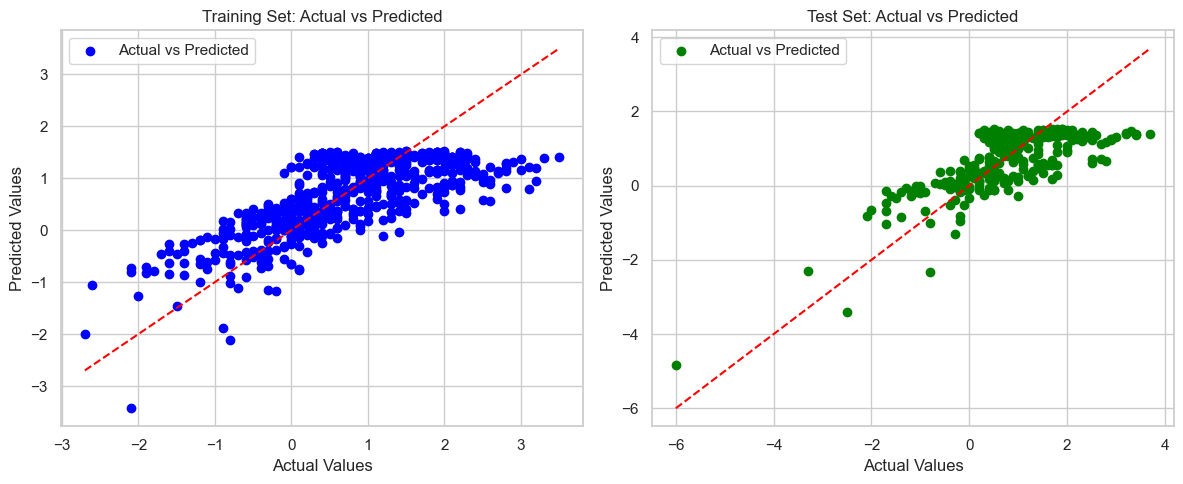

In [90]:


# Lisa mudelisel konstant
X_train = sm.add_constant(X_train)

# Sobita regressioonimudel
model = sm.OLS(Y_train, X_train).fit()

# Prindi regressiooni tulemused
print("Training Model Summary:")
print(model.summary())

# Prognoosi treening- ja valideerimisandmete peal
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(sm.add_constant(X_test))

# Arvuta R² treening- ja valideerimisandmete jaoks
train_r2 = r2_score(Y_train, Y_train_pred)
test_r2 = r2_score(Y_test, Y_test_pred)

print(f"\nTraining R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")

# Plot the actual vs predicted values for training and testing sets
plt.figure(figsize=(12, 5))

# Plot for training set
plt.subplot(1, 2, 1)
plt.scatter(Y_train, Y_train_pred, color='blue', label='Actual vs Predicted')
plt.plot([Y_train.min(), Y_train.max()], [Y_train.min(), Y_train.max()], '--', color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Training Set: Actual vs Predicted')
plt.legend()
plt.grid(True)

# Plot for test set
plt.subplot(1, 2, 2)
plt.scatter(Y_test, Y_test_pred, color='green', label='Actual vs Predicted')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], '--', color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Test Set: Actual vs Predicted')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [91]:
## Võta mudeli parameetrid

In [92]:


# Võta mudeli koefitsiendid
coefficients = model.params

# Koosta regressioonivõrrand (mudel)
equation = "Y = " + str(coefficients[0])  # Start with the intercept
for i, col in enumerate(X_train.columns[1:]):  # Skip the constant term
    equation += f" + ({coefficients[i + 1]}) * {col}"

print("Mudel (regressioonivõrrand):")
print(equation)

Mudel (regressioonivõrrand):
Y = 1.5146545622113097 + (-0.0030609301150566733) * dem_1


C:\Users\kevelyn\AppData\Local\Temp\ipykernel_23912\3499799764.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  equation = "Y = " + str(coefficients[0])  # Start with the intercept
C:\Users\kevelyn\AppData\Local\Temp\ipykernel_23912\3499799764.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  equation += f" + ({coefficients[i + 1]}) * {col}"
